In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import random
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, MobileNetV2, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [3]:
# Path dataset
base_dir = "/kaggle/input/vegetable-image-dataset/Vegetable Images"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

In [4]:
# Parameter
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Preprocessing Citra

In [5]:
# Augmentasi data dan normalisasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


## Contoh Gambar dari Dataset

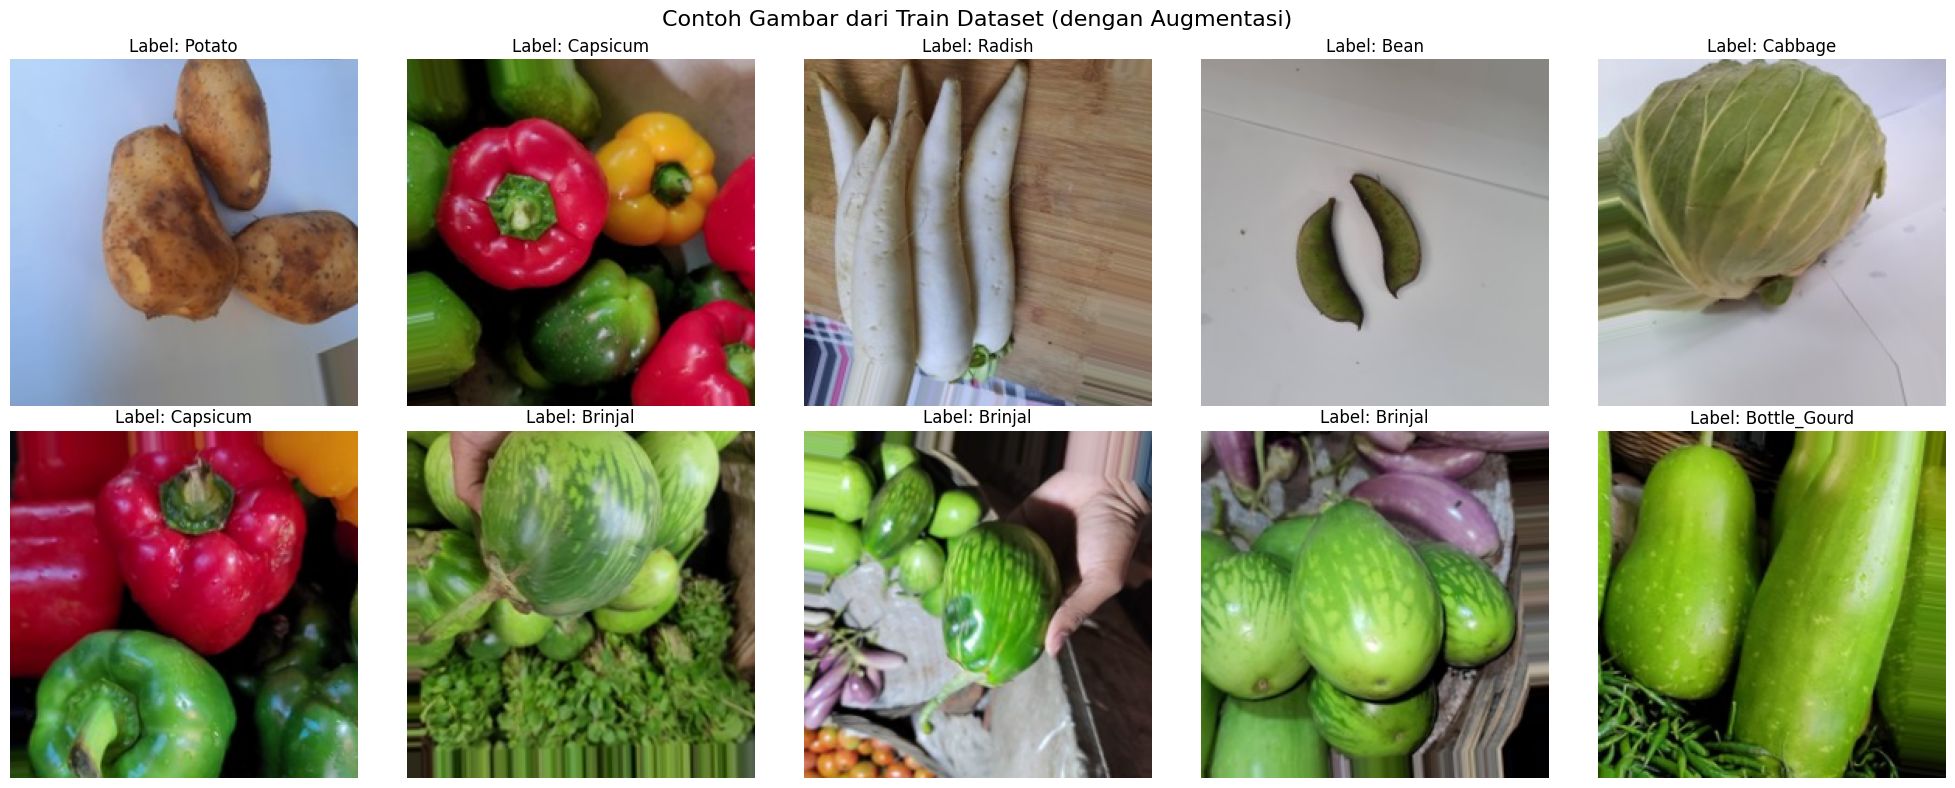

In [6]:
images, labels = next(train_generator)  # Ambil satu batch pertama

class_names = list(train_generator.class_indices.keys())
plt.figure(figsize=(20, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    plt.title(f"Label: {class_names[label_index]}")
    plt.axis('off')
plt.suptitle("Contoh Gambar dari Train Dataset (dengan Augmentasi)", fontsize=16)
plt.tight_layout()
plt.show()


In [7]:
# Konfirmasi jumlah kelas
NUM_CLASSES = train_generator.num_classes
print(f"Jumlah kelas: {NUM_CLASSES}")
print(f"Label: {list(train_generator.class_indices.keys())}")

Jumlah kelas: 15
Label: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


# Implementasi Arsitektur

In [8]:
# Fungsi untuk membuat model dengan arsitektur tertentu
def build_model(base_model_fn, input_shape=(224, 224, 3), num_classes=15):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [9]:
# Callback untuk learning rate scheduler
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1
)

In [10]:
# Dictionary arsitektur
models = {
    "VGG16": VGG16,
    "MobileNetV2": MobileNetV2,
    "ResNet50": ResNet50
}

# Untuk menyimpan history & hasil
history_all = {}
results = {}

# Pelatihan dan Evaluasi

In [11]:
# Loop training per model
for name, base_fn in models.items():
    print(f"\nTraining model: {name}\n")
    
    model = build_model(base_fn, input_shape=(224, 224, 3), num_classes=NUM_CLASSES)
    
    start_train = time.time()
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator,
        callbacks=[lr_reducer],
        verbose=1
    )
    training_time = time.time() - start_train
    
    # Evaluasi
    test_loss, test_acc = model.evaluate(test_generator, verbose=0)
    print(f"Test accuracy for {name}: {test_acc:.4f}")
    
    start_pred = time.time()
    y_pred_probs = model.predict(test_generator)
    inference_time = time.time() - start_pred
    
    # Prediksi
    y_true = test_generator.classes
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Confusion matrix dan classification report
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(
        y_true,
        y_pred,
        target_names=test_generator.class_indices.keys(),
        output_dict=True
    )
    
    # Menyimpan hasil
    results[name] = {
        "accuracy": test_acc,
        "confusion_matrix": cm,
        "classification_report": cr,
        "training_time": training_time,
        "inference_time": inference_time,
        "model": model
    }
    
    history_all[name] = history


Training model: VGG16



I0000 00:00:1744448118.285953     425 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744448118.286633     425 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744448129.499903     504 service.cc:148] XLA service 0x7ee3f001e510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744448129.499962     504 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744448129.499969     504 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744448130.108403     504 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744448168.379469     504 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

469/469 ━━━━━━━━━━━━━━━━━━━━ 347s 637ms/step - accuracy: 0.4212 - loss: 1.7659 - val_accuracy: 0.9450 - val_loss: 0.1984 - learning_rate: 1.0000e-04
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 249s 524ms/step - accuracy: 0.9359 - loss: 0.2349 - val_accuracy: 0.9790 - val_loss: 0.0691 - learning_rate: 1.0000e-04
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 249s 524ms/step - accuracy: 0.9622 - loss: 0.1338 - val_accuracy: 0.9810 - val_loss: 0.0661 - learning_rate: 1.0000e-04
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 248s 523ms/step - accuracy: 0.9784 - loss: 0.0740 - val_accuracy: 0.9817 - val_loss: 0.0668 - learning_rate: 1.0000e-04
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 248s 523ms/step - accuracy: 0.9746 - loss: 0.0935 - val_accuracy: 0.9830 - val_loss: 0.0621 - learning_rate: 1.0000e-04
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 248s 522ms/step - accuracy: 0.9832 - loss: 0.0581 - val_accuracy: 0.9943 - val_loss: 0.0254 - learning_rate: 1.0000e-04
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 248s 523ms/

# Analisis Kinerja

In [12]:
# Fungsi untuk menampilkan metrik
def display_metrics(results):
    for name, res in results.items():
        print(f"\nModel: {name}")
        print(f"Akurasi Uji: {res['accuracy']:.4f}")
        print(f"Waktu Training: {res['training_time']:.2f} detik")
        print(f"Waktu Inference: {res['inference_time']:.2f} detik\n")
        print("----------------------------------------------------\n")

    for name, res in results.items():
        print(f"\nKinerja Model {name}")
        cr_df = pd.DataFrame(res['classification_report']).transpose()
        display(cr_df[['precision', 'recall', 'f1-score', 'support']])

display_metrics(results)


Model: VGG16
Akurasi Uji: 0.9983
Waktu Training: 2581.79 detik
Waktu Inference: 18.25 detik

----------------------------------------------------


Model: MobileNetV2
Akurasi Uji: 0.9997
Waktu Training: 1837.41 detik
Waktu Inference: 12.26 detik

----------------------------------------------------


Model: ResNet50
Akurasi Uji: 0.7117
Waktu Training: 1892.05 detik
Waktu Inference: 17.03 detik

----------------------------------------------------


Kinerja Model VGG16


precision    recall  f1-score      support
Bean           1.000000  0.995000  0.997494   200.000000
Bitter_Gourd   1.000000  0.995000  0.997494   200.000000
Bottle_Gourd   1.000000  1.000000  1.000000   200.000000
Brinjal        1.000000  1.000000  1.000000   200.000000
Broccoli       0.990099  1.000000  0.995025   200.000000
Cabbage        1.000000  0.995000  0.997494   200.000000
Capsicum       1.000000  1.000000  1.000000   200.000000
Carrot         1.000000  1.000000  1.000000   200.000000
Cauliflower    0.994975  0.990000  0.992481   200.000000
Cucumber       0.995025  1.000000  0.997506   200.000000
Papaya         1.000000  1.000000  1.000000   200.000000
Potato         1.000000  1.000000  1.000000   200.000000
Pumpkin        0.995025  1.000000  0.997506   200.000000
Radish         1.000000  1.000000  1.000000   200.000000
Tomato         1.000000  1.000000  1.000000   200.000000
accuracy       0.998333  0.998333  0.998333     0.998333
macro avg      0.998342  0.998333  0.998333  3000.000000
weighted avg   0.998342  0.998333  0.998333  3000.000000


Kinerja Model MobileNetV2


precision    recall  f1-score      support
Bean           1.000000  1.000000  1.000000   200.000000
Bitter_Gourd   1.000000  0.995000  0.997494   200.000000
Bottle_Gourd   1.000000  1.000000  1.000000   200.000000
Brinjal        0.995025  1.000000  0.997506   200.000000
Broccoli       1.000000  1.000000  1.000000   200.000000
Cabbage        1.000000  1.000000  1.000000   200.000000
Capsicum       1.000000  1.000000  1.000000   200.000000
Carrot         1.000000  1.000000  1.000000   200.000000
Cauliflower    1.000000  1.000000  1.000000   200.000000
Cucumber       1.000000  1.000000  1.000000   200.000000
Papaya         1.000000  1.000000  1.000000   200.000000
Potato         1.000000  1.000000  1.000000   200.000000
Pumpkin        1.000000  1.000000  1.000000   200.000000
Radish         1.000000  1.000000  1.000000   200.000000
Tomato         1.000000  1.000000  1.000000   200.000000
accuracy       0.999667  0.999667  0.999667     0.999667
macro avg      0.999668  0.999667  0.999667  3000.000000
weighted avg   0.999668  0.999667  0.999667  3000.000000


Kinerja Model ResNet50


precision    recall  f1-score      support
Bean           0.955882  0.650000  0.773810   200.000000
Bitter_Gourd   0.895000  0.895000  0.895000   200.000000
Bottle_Gourd   0.909091  0.650000  0.758017   200.000000
Brinjal        0.500000  0.565000  0.530516   200.000000
Broccoli       0.987805  0.810000  0.890110   200.000000
Cabbage        0.397028  0.935000  0.557377   200.000000
Capsicum       0.914634  0.750000  0.824176   200.000000
Carrot         0.595166  0.985000  0.741996   200.000000
Cauliflower    0.645161  0.900000  0.751566   200.000000
Cucumber       0.964286  0.675000  0.794118   200.000000
Papaya         1.000000  0.375000  0.545455   200.000000
Potato         0.857143  0.240000  0.375000   200.000000
Pumpkin        0.687805  0.705000  0.696296   200.000000
Radish         0.983471  0.595000  0.741433   200.000000
Tomato         0.653979  0.945000  0.773006   200.000000
accuracy       0.711667  0.711667  0.711667     0.711667
macro avg      0.796430  0.711667  0.709858  3000.000000
weighted avg   0.796430  0.711667  0.709858  3000.000000

# Visualisasi Hasil

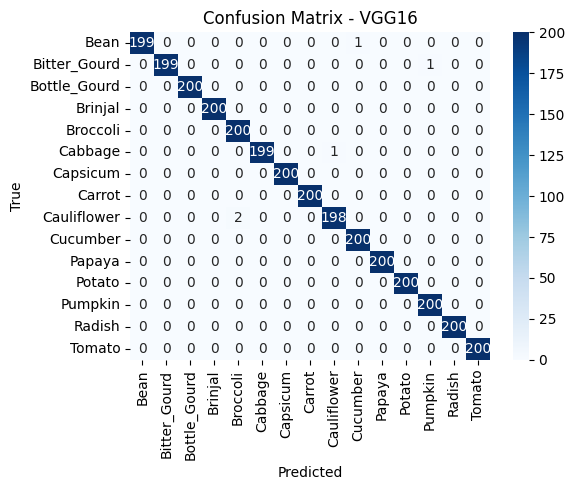

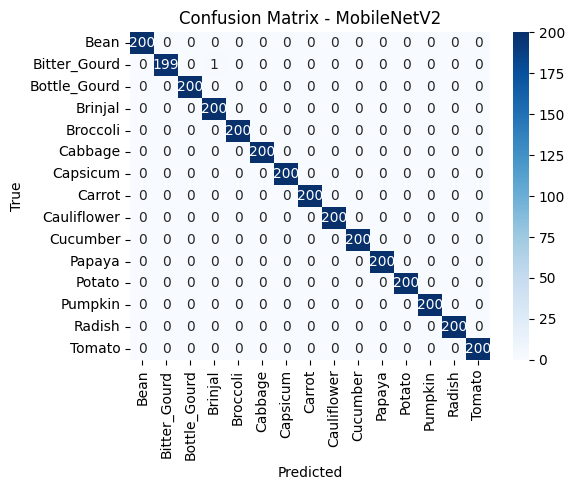

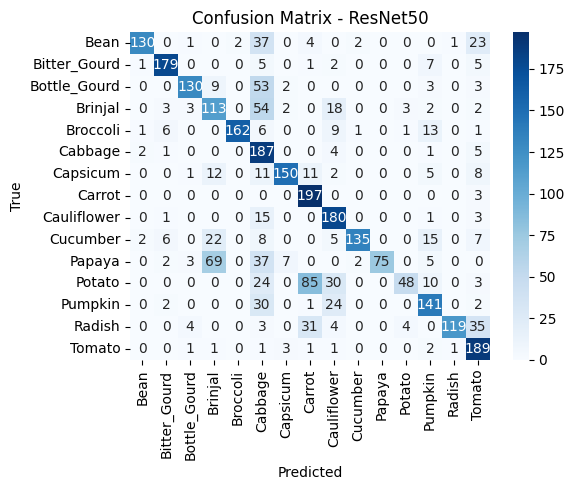

In [13]:
# Fungsi untuk menampilkan confusion matrix
def display_confusion_matrix(results):
    for name, res in results.items():
        plt.figure(figsize=(6, 5))
        sns.heatmap(res['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                    xticklabels=test_generator.class_indices.keys(),
                    yticklabels=test_generator.class_indices.keys())
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

display_confusion_matrix(results)

## Plot Akurasi dan Loss Tiap Model

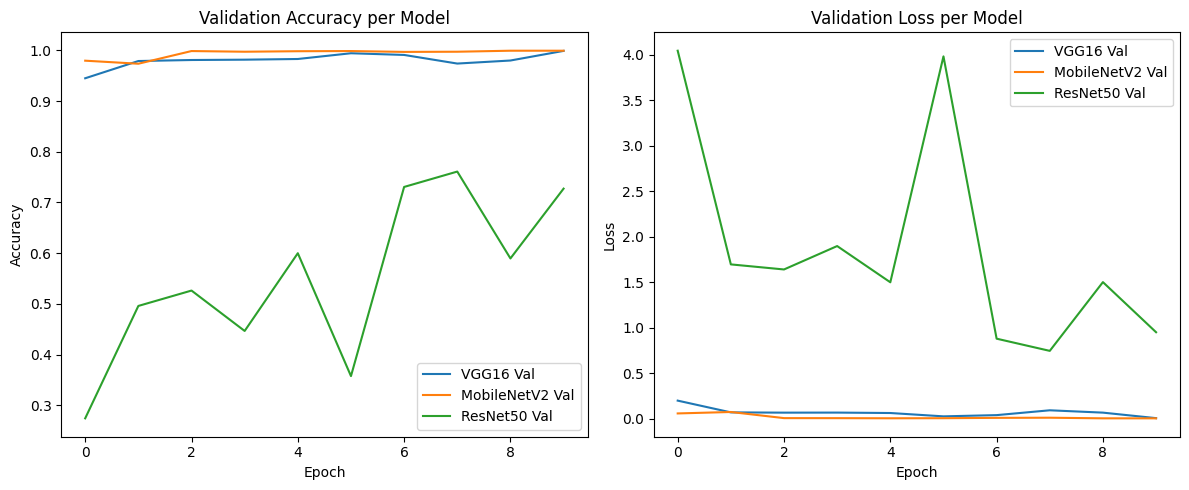

In [14]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
for name, history in history_all.items():
    plt.plot(history.history['val_accuracy'], label=f'{name} Val')
plt.title("Validation Accuracy per Model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
for name, history in history_all.items():
    plt.plot(history.history['val_loss'], label=f'{name} Val')
plt.title("Validation Loss per Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

## Kinerja dan Visualisasi Confusion Matrix dari Model Terbaik


Kinerja Model Terbaik: MobileNetV2
Akurasi Uji     : 0.9997
Waktu Training  : 1837.41 detik
Waktu Inference : 12.26 detik


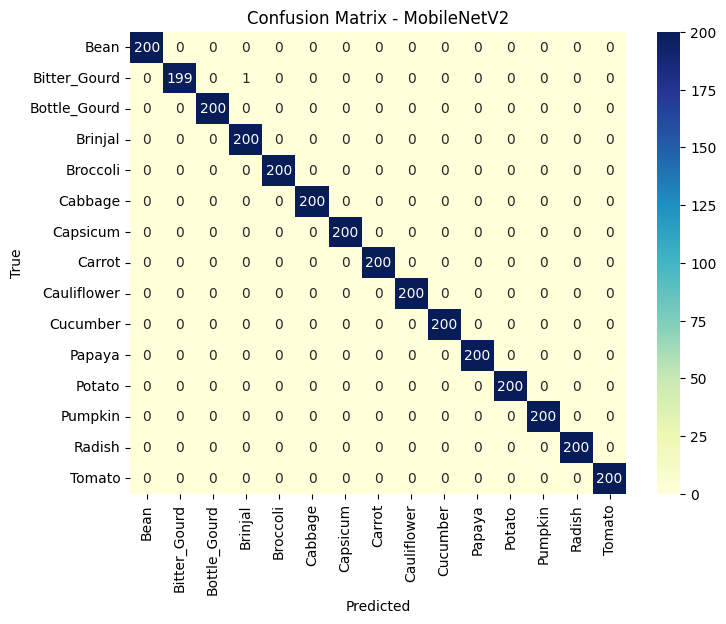

In [15]:
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_result = results[best_model_name]

print(f"\nKinerja Model Terbaik: {best_model_name}")
print(f"Akurasi Uji     : {best_result['accuracy']:.4f}")
print(f"Waktu Training  : {best_result['training_time']:.2f} detik")
print(f"Waktu Inference : {best_result['inference_time']:.2f} detik")

# Confusion matrix
best_cm = results[best_model_name]['confusion_matrix']

plt.figure(figsize=(8, 6))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Menampilkan beberapa prediksi gambar dari model terbaik

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step


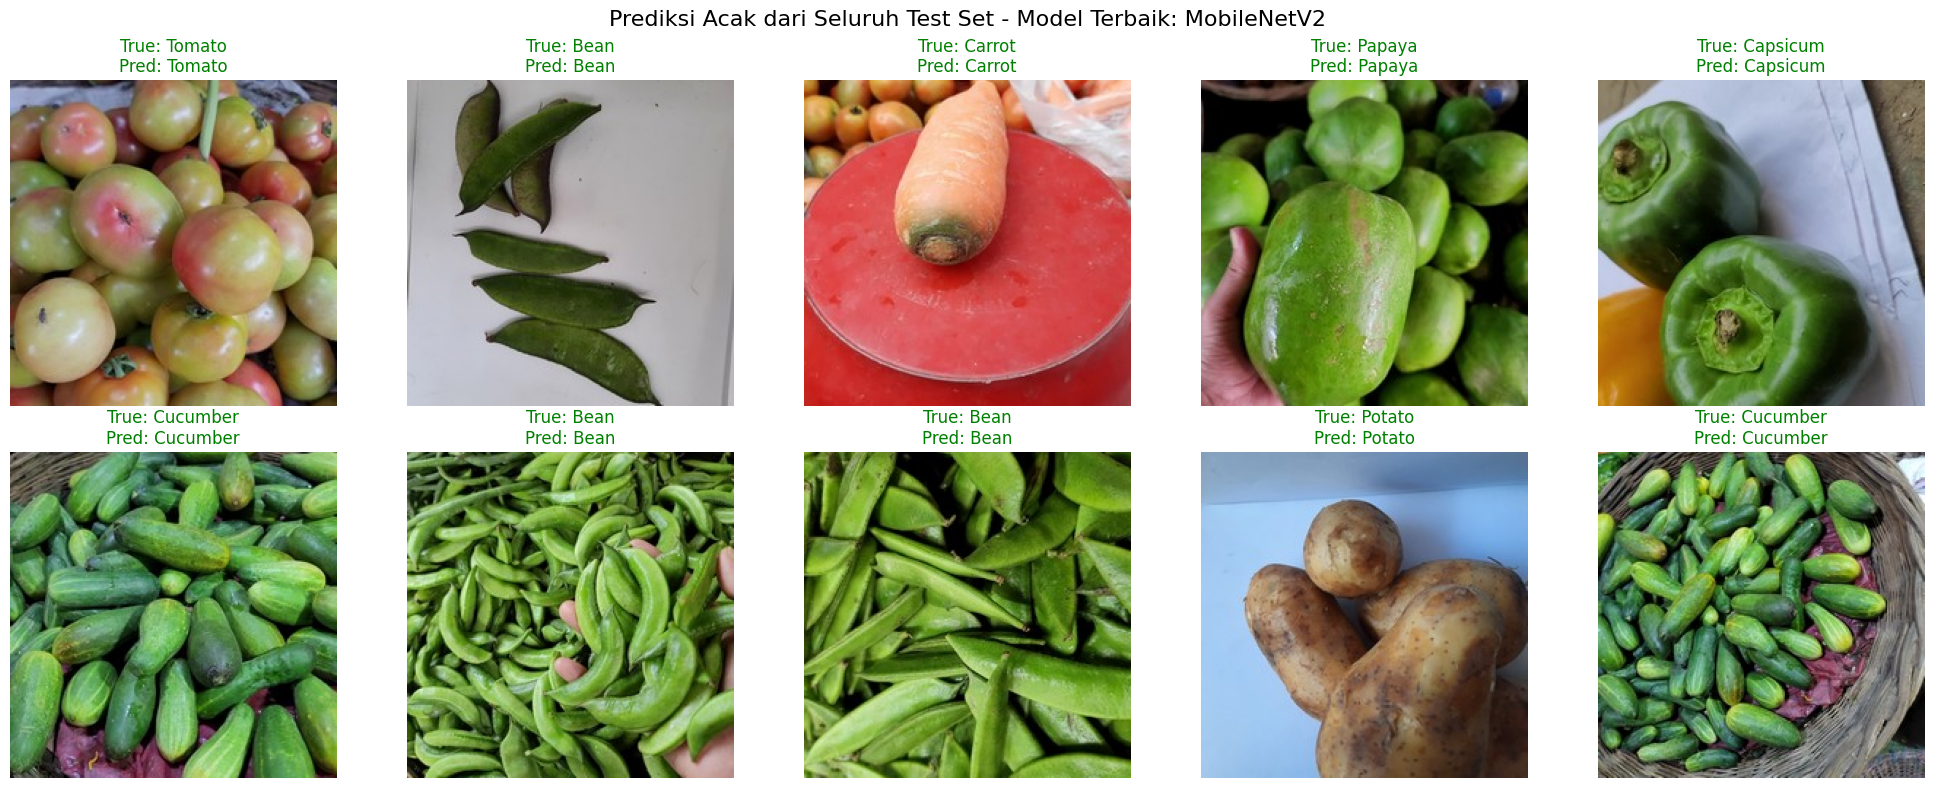

In [16]:
best_model = results[best_model_name]['model']

test_generator.reset()

all_images = []
all_labels = []

for _ in range(len(test_generator)):
    imgs, lbls = next(test_generator)
    all_images.extend(imgs)
    all_labels.extend(lbls)

all_images = np.array(all_images)
all_labels = np.array(all_labels)

pred_probs = best_model.predict(all_images)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = np.argmax(all_labels, axis=1)

class_names = list(test_generator.class_indices.keys())

# Ambil 10 indeks acak dari seluruh test set
random_indices = np.random.choice(len(all_images), size=10, replace=False)

# Visualisasi
plt.figure(figsize=(20, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(all_images[idx])
    plt.title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[pred_labels[idx]]}",
              color='green' if true_labels[idx] == pred_labels[idx] else 'red')
    plt.axis('off')

plt.suptitle(f"Prediksi Acak dari Seluruh Test Set - Model Terbaik: {best_model_name}", fontsize=16)
plt.tight_layout()
plt.show()